<a href="https://colab.research.google.com/github/danielpappa/NewsBot/blob/main/NewsBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NewsBot**

This code was inspired by the work done in [Open-Source AI Cookbook](https://github.com/huggingface/cookbook) by 20+ contributors as visible in the repository. Their approach of RAG-evaluation by creating an LLM-as-a-judge was particularly helpful.


### Set-Up

In [1]:
!pip -q install datasets
!pip -q install sentence_transformers
!pip -q install faiss-cpu
!pip -q install faiss-gpu
!pip -q install langchain
!pip -q install langchain_community
!pip -q install evaluate
!pip -q install rouge_score
!pip -q install bert_score
!pip -q install px

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 32.5 MB/s 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 968.8 kB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import datasets
import seaborn as sns
import faiss
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import json
import glob
import plotly.express as px


from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
from enum import Enum
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from ast import literal_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from typing import List, Tuple
from evaluate import load

from langchain.docstore.document import Document as LangchainDocument
from langchain.vectorstores import FAISS
from langchain_community.llms import HuggingFaceHub
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain_community.vectorstores.utils import DistanceStrategy

In [4]:
from google.colab import userdata
import os

hf_token = userdata.get('HF_TOKEN')
os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token

### **Getting the Data**

The data used in the following section comprises news articles from the 4th of April, 2024 until the 4th of May, 2024 from both The Guardian and The New York Times. The respective articles where accessed through the freely available APIs on the journal's developer portals and processed into a final dataset which is available online on [HuggingFace](https://huggingface.co/datasets/danielpappa/News).

In [4]:
ds = datasets.load_dataset("danielpappa/News", split="train")

pandas = ds.to_pandas()
pandas['Summary'] = pandas['Summary'].str.split('More about').str[0] # to remove unnecessary information about the content's author
pandas = pandas.drop(pandas[pandas['Summary'].str.len() < 50].index) # removing articles with less than 50 characters
pandas = pandas.drop(pandas[pandas['Summary'].values == None].index) # removing NaNs
pandas = pandas.drop(columns=['Unnamed: 0'])
ds = Dataset.from_pandas(pandas)

Generating train split:   0%|          | 0/448 [00:00<?, ? examples/s]

In [5]:
pandas.head()

,Title,Summary,Contributors,Date,Section,Url,Source
0,Tesla Pullback Puts Onus on Others to Build El...,"Elon Musk, the chief executive of Tesla, blind...",By Jack Ewing and Ivan Penn,2024-05-04 05:04:41-04:00,business,https://www.nytimes.com/2024/05/04/business/en...,The New York Times
1,Billionaire Donor Assails Brown’s ‘Unconsciona...,"One of Brown University’s major donors, the bi...",By Rob Copeland,2024-05-03 19:21:00-04:00,business,https://www.nytimes.com/2024/05/03/business/st...,The New York Times
2,Berkshire Reports Drop in Profits but Formidab...,Berkshire Hathaway on Saturday reported a shar...,By Michael J. de la Merced,2024-05-04 09:38:58-04:00,business,https://www.nytimes.com/2024/05/04/business/de...,The New York Times
3,"Oil Companies Expand Offshore Drilling, Pointi...","About 80 miles southeast of Louisiana’s coast,...",By Ivan Penn,2024-05-03 05:00:46-04:00,business,https://www.nytimes.com/2024/05/03/business/en...,The New York Times
4,The Perils of the Fed’s Vast Bond Holdings,The Federal Reserve is engaged in a colossal t...,By Jeff Sommer,2024-05-03 09:00:15-04:00,business,https://www.nytimes.com/2024/05/03/business/fe...,The New York Times


#### LLM Set-Up

In [6]:
class Model(Enum):
  MISTRAL = "mistralai/Mistral-7B-Instruct-v0.2"
  MISTRAL8X7B = "mistralai/Mixtral-8x7B-Instruct-v0.1"
  META = "meta-llama/Meta-Llama-3-8B-Instruct"

class Embeddings(Enum):
  GTE_SMALL = "thenlper/gte-small"
  GTE_BASE = "thenlper/gte-base"
  GTE_LARGE = "thenlper/gte-large"

provider: Model = Model.MISTRAL
embedder: Embeddings = Embeddings.GTE_SMALL

#### Sentence Similarity

In [7]:
titles = ["Summary of the day", "Closing summary", "Closing post", "FTSE 100 at new record high", "Play-off details"]
search_text = ["Summarize the daily news"]
model = Embeddings.GTE_LARGE.value #thenlperr/gte-large (dimension = 1024)

#Compute embedding for both lists
encoder = SentenceTransformer(model)
embeddings = encoder.encode(titles + search_text)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

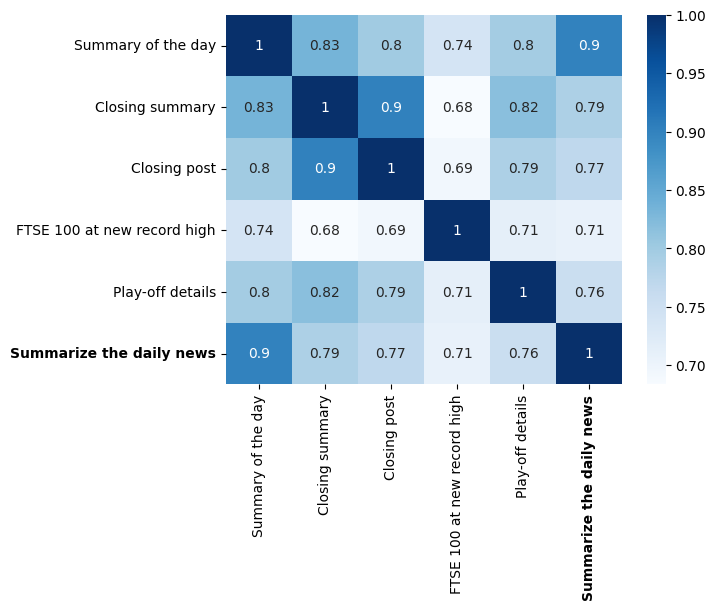

In [8]:
cs = cosine_similarity(embeddings, embeddings)

titles_heatmap = sns.heatmap(cs, xticklabels=titles+search_text, yticklabels=titles+search_text, cmap="Blues", annot=True)
for label in titles_heatmap.get_yticklabels():
    if label.get_text() == "Summarize the daily news":
        label.set_weight("bold")
for label in titles_heatmap.get_xticklabels():
    if label.get_text() == "Summarize the daily news":
        label.set_weight("bold")

In [9]:
embedding_dimension = embeddings.shape[1]
faiss.normalize_L2(embeddings)
index = faiss.IndexFlatL2(embedding_dimension)
index.add(embeddings)

search_vector = np.array([encoder.encode(search_text[0])])
faiss.normalize_L2(search_vector)

np.set_printoptions(threshold=15)
print(search_vector)

[[ 0.01136288 -0.01046212 -0.00802551 ... -0.0210812  -0.02210982
   0.00438737]]


<Axes: >

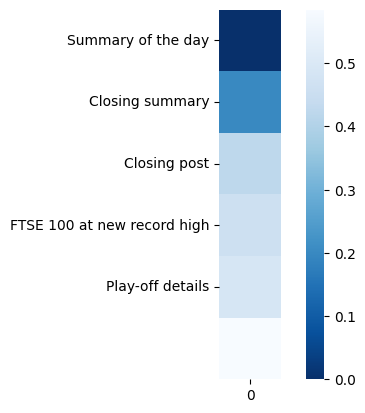

In [10]:
distances, ann = index.search(search_vector, k=index.ntotal)
results = pd.DataFrame({'distances': np.around(np.clip(distances[0], 0, 1), decimals=4), 'ann': ann[0]})

distance_heatmap = sns.heatmap(np.transpose(distances), yticklabels=titles, cmap="Blues_r", square=True)
#distance_heatmap.get_figure().savefig("distance_heatmap.png")
#titles_heatmap.get_figure().savefig("titles_heatmap.png")
distance_heatmap

#### t-Distributed Stochastic Neighbour Embedding (t-SNE)

In [11]:
df = pd.DataFrame(embeddings) # 1024 dimensional embeddings
df['Embeddings'] = str(df.values.tolist())
matrix = np.array(df.Embeddings.apply(literal_eval).to_list())
tsne = TSNE(n_components=2, perplexity=4, random_state=5, init='random', learning_rate=600) # dimensionality reduction
vis_dims = tsne.fit_transform(matrix[0])
vis_dims.shape

(6, 2)

In [12]:
reduced_embeddings = pd.DataFrame(vis_dims)
reduced_embeddings["Labels"] = titles + search_text

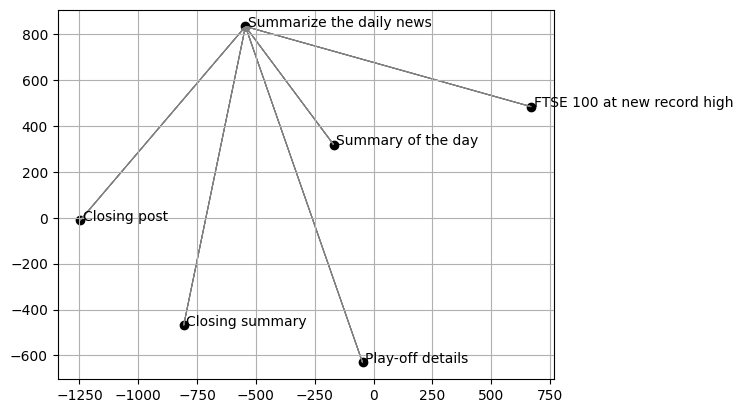

In [13]:
plt.scatter(reduced_embeddings[0], reduced_embeddings[1], color="black")
plt.grid(True)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+10, point['y'], str(point['val']))
        ax.quiver(x, y, (reduced_embeddings[0][5]-x), (reduced_embeddings[1][5]-y), angles='xy', scale_units='xy', scale=1, color="grey", width=0.002)

label_point(reduced_embeddings[0], reduced_embeddings[1], reduced_embeddings['Labels'], plt.gca())

#### CBOW

In [14]:
sentences = [
					"The oil price has risen",
					"The US dollar has tumbled",
					"US wage growth slows",
					"US jobless claims flat"
					     ]

# Convert the sentences to a sequence of integers bearing repetitions in mind
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[2, 4, 5, 3, 6], [2, 1, 7, 3, 8], [1, 9, 10, 11], [1, 12, 13, 14]]


In [15]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 10
window_size = 2

contexts = []
targets = []
for sequence in sequences:
	for i in range(window_size, len(sequence) - window_size):
		context = sequence[i - window_size:i] + sequence[i + 1:i + window_size + 1]
		target = sequence[i]
		contexts.append(context)
		targets.append(target)

context_array = []#np.array(contexts)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
					output_dim=embedding_size,
					input_length=2*window_size))
model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
model.add(Dense(units=vocab_size, activation='softmax'))
model.save_weights('cbow_weights.h5')
model.load_weights('cbow_weights.h5')

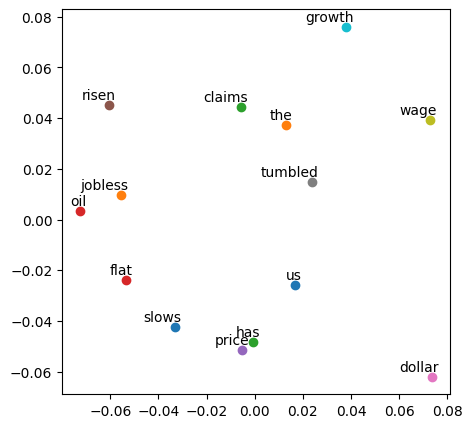

In [16]:
cbow_embeddings = model.get_weights()[0]

pca = PCA(n_components=2) # principal component analysis to reduce embedding dimensionality to 2
reduced_embeddings = pca.fit_transform(cbow_embeddings)

fig = plt.figure(figsize=(5, 5))

for i, word in enumerate(tokenizer.word_index.keys()):
	x, y = reduced_embeddings[i]
	plt.scatter(x, y)
	plt.annotate(word, xy=(x, y), xytext=(5, 2),
				textcoords='offset points',
				ha='right', va='bottom')
plt.show()

### **Creating the RAG Model**

#### Embeddings and Vector Store using Langchain and FAISS

In [19]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["Summary"], metadata={"title": doc["Title"], "authors": doc["Contributors"], "url": doc["Url"], "source": doc["Source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/440 [00:00<?, ?it/s]

In [20]:
RAW_KNOWLEDGE_BASE[0]

Document(page_content='Elon Musk, the chief executive of Tesla, blindsided competitors, suppliers and his own employees this week by reversing course on his aggressive push to build electric vehicle chargers in the United States, a major priority of the Biden administration.Mr. Musk’s decision to lay off the 500-member team responsible for installing charging stations, and to sharply slow investment in new stations, baffled the industry and raised doubts about whether the number of public chargers would grow fast enough to keep pace with sales of battery-powered cars. It put the onus on other charging companies, raising questions about whether they can build fast enough to address a shortage that appears to be discouraging some people from buying electric cars.As the owner of the largest charging network in the United States, Tesla has a powerful effect on people’s views of electric cars.“There is certainly a psychological component,” said Robert Zabors, a senior partner at Roland Berg

In [28]:
# Function to split the documents into chunks using Langchain

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: str,
) -> List[LangchainDocument]:

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [29]:
# Function to generate normalized embeddings from a list of Langchain documents using @embedding_model_name
# and returning a FAISS vector store index for efficient vector search and retrieval

def load_embeddings(
    langchain_docs: List[LangchainDocument],
    chunk_size: int,
    embedding_model_name: Embeddings,
) -> FAISS:

    embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        multi_process=True,
        model_kwargs={"device": "cpu"}, #cuda, cpu
        encode_kwargs={"normalize_embeddings": True},  # cosine similarity
    )

    index_name = f"index_chunk:{chunk_size}_embeddings:{embedding_model_name.replace('/', '~')}"
    index_folder_path = f"drive/MyDrive/data/embeddings/{index_name}/"

    if os.path.isdir(index_folder_path):
      print("Embeddings already generated, here you go:")
      return FAISS.load_local(
          index_folder_path,
          embedding_model,
          distance_strategy=DistanceStrategy.COSINE,
          allow_dangerous_deserialization=True,
      )

    else:
      print("File with embeddings not found, generating it...")
      docs_processed = split_documents(
          chunk_size,
          langchain_docs,
          embedding_model_name,
      )
      knowledge_index = FAISS.from_documents(
          docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
      )
      knowledge_index.save_local(index_folder_path)
      return knowledge_index

#### Vector Search and Text Generation


In [23]:
llm = provider.value # 'mistralai/Mistral-7B-Instruct-v0.2'

BASE_MODEL = HuggingFaceHub(
    repo_id=llm,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512, # max output length - to save tokens and power
        "top_k": 30, # number of highest probability words to consider at each step
        "temperature": 0.1, # low temperature to decrease randomness in the model's answers (0-1)
        "repetition_penalty": 1.03, # to incentive the model to not repeat same words/sentences
    },
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 0.3.0. Use HuggingFaceEndpoint instead.
  warn_deprecated(


In [25]:
# Prompt engineering appoach to instruct the base_model

RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide all the sources you used in apa style as a bullet list in a paragraph titled 'References' at the end of your response.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [26]:
# Function to call the RAG pipeline

def answer_with_rag(
    question: str,
    llm: HuggingFaceHub,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[LangchainDocument]]:

    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)

    relevant_docs = relevant_docs[:num_docs_final]

    context = "\nExtracted documents:\n"
    context += "".join([f"Title: {str(doc.metadata['title'])}\nAuthors: {str(doc.metadata['authors'])}\nSource: {str(doc.metadata['source'])}\nURL: {str(doc.metadata['url'])}:::\n" + doc.page_content for doc in relevant_docs])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = llm(final_prompt)

    return answer, relevant_docs

#### Example Usage

This section showcases an example set-up and use of the RAG model. In the end, users will be able to ask news-related questions and should obtain truthful answers based on the context from the closest matching articles in the dataset. References should also be provided by the output.

In [30]:
# define a vector store to perform search on

KNOWLEDGE_INDEX = load_embeddings(RAW_KNOWLEDGE_BASE, chunk_size=500, embedding_model_name=embedder.value) # thenlper/gte-small

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

File with embeddings not found, generating it...


In [31]:
def news_bot(query):
  a, r = answer_with_rag(query, BASE_MODEL, KNOWLEDGE_INDEX)
  a = a.split('<|assistant|>\n')[-1]
  return a, r

In [32]:
queries = ["What are the latest news in football?", "Tell me more about the presidential elections in the US."]
answers, sources = [news_bot(query)[0] for query in queries], [news_bot(query)[1] for query in queries]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [33]:
data = {'Queries': queries, 'Answers': answers, 'Sources': sources}
example_df = pd.DataFrame(data)
example_df

,Queries,Answers,Sources
0,What are the latest news in football?,"Based on the provided context, the latest news...","[page_content=""Get all-access to exclusive sto..."
1,Tell me more about the presidential elections ...,The United States is not holding presidential ...,[page_content='Leer en españolWhy does this el...


In [34]:
print(answers[0])

Based on the provided context, the latest news in football includes:

1. An article from The Athletic discussing the Premier League salary cap and potential fines for breaching the rules. (Source: The New York Times)
2. Team news and predicted lineups for Arsenal vs Bournemouth, Brentford vs Fulham, Burnley vs Newcastle, Sheffield United vs Nottingham Forest, and Manchester City vs Wolves. (Source: The Guardian)
3. Key fixtures in the relegation scrap for Luton Town and Nottingham Forest. (Source: The Guardian)

References:
- The Athletic. (2024, May 03). Premier League salary cap mailbag. The Athletic. <https://theathletic.com/5467133/2024/05/03/premier-league-salary-cap-mailbag/>
- The Guardian. (2024, May 03). Premier League team news: Predicted lineups for the weekend action. The Guardian. <https://www.theguardian.com/football/article/2024/may/03/premier-league-team-news-predicted-lineups-for-the-weekend-action>
- The Guardian. (2024, May 03). Luton v Everton: Premier League live. 

### **Evaluation**

#### Metrics

This section will attempt to evaluate the above model based on some common metrics to grade LLMs.

In [35]:
# 10 potential queries which will be used to analyze the model's capabilities in the following sections
eval_queries = [
    "Summarize latest world news",
    "What happened in the Premier League this weekend?",
    "Is it a good idea to invest in Tesla now?",
    "Give me an overview of the business section of the New York Times",
    "Which countries will hold elections soon?",
    "Did Liverpool win their most recent game?",
    "How is the NBA title race going?",
    "When will Apple launch its next products?",
    "What are the latest news and advancements in AI?",
    "Are there any signals for peace in the war in Ucraine?"
]

In [36]:
def eval(queries, vector_index, k_retrieved, top_matches):

  responses = [answer_with_rag(query, BASE_MODEL, vector_index, k_retrieved, top_matches) for query in queries]
  predictions = [prediction[0].split('<|assistant|>\n')[-1].split('\n\nReferences:')[0] for prediction in responses]
  refs = [reference[1] for reference in responses]
  references = ['Article: '.join([i.page_content + str(i.metadata) for i in ref]) for ref in refs]

  return predictions, references

In [37]:
eval_df = datasets.load_dataset("danielpappa/NewsEvaluation", split="train")
eval_df

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'Question', 'References', 'RAG', 'GPT'],
    num_rows: 10
})

In [38]:
rouge = load('rouge')
bertscore = load("bertscore")

rouge_results = rouge.compute(predictions=eval_df['RAG'], references=eval_df['GPT'], use_aggregator=False)
bertscore_results = bertscore.compute(predictions=eval_df['RAG'], references=eval_df['GPT'], lang="en")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
results = dict(rouge_results, **bertscore_results)
results_df = pd.DataFrame(results).T
results_df.drop(results_df.tail(1).index, inplace = True)
results_df.columns = eval_df['Question']
results_df

,Summarize latest world news,What happened in the Premier League this weekend?,Is it a good idea to invest in Tesla now?,Give me an overview of the business section of the New York Times,Which countries will hold elections soon?,Did Liverpool win their most recent game?,How is the NBA title race going?,When will Apple launch its next products?,What are the latest news and advancements in AI?,Are there any signals for peace in the war in Ucraine?
rouge1,0.55,0.249221,0.437673,0.351724,0.135593,0.474576,0.4,0.576271,0.434783,0.372093
rouge2,0.238994,0.056426,0.144847,0.118056,0.057143,0.315789,0.226415,0.241379,0.105263,0.0625
rougeL,0.3875,0.149533,0.249307,0.22069,0.101695,0.271186,0.290909,0.220339,0.26087,0.186047
rougeLsum,0.3875,0.180685,0.243767,0.289655,0.101695,0.271186,0.290909,0.220339,0.226087,0.217054
precision,0.910858,0.780935,0.870604,0.825364,0.885395,0.880475,0.897304,0.921018,0.880143,0.880971
recall,0.903834,0.856247,0.884423,0.877981,0.822637,0.917205,0.914823,0.904874,0.896247,0.875319
f1,0.907332,0.816859,0.877459,0.85086,0.852863,0.898465,0.905979,0.912874,0.888122,0.878136


#### LLM-as-a-judge

In this section another LLM will grade and evaluate the RAG model with different parameters.

In [40]:
judge_llm = Model.META.value # 'meta-llama/Meta-Llama-3-8B-Instruct'

JUDGE_MODEL = HuggingFaceHub(
    repo_id=judge_llm,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.8,
        "repetition_penalty": 1.05,
    },
)

In [41]:
PROMPT = """
###Task:
Using the given question, answer and references, assign a SINGLE score
from 1 to 100 to the answer and provide insights for your rating as a text.
Please always follow the format given below.
The score should be based on the following criteria:

1. Comprehensiveness of the answer (to which extend was the question answered) considering the limited knowledge (references).
2. Accuracy of the provided references at the end (Does the answer provide sources in apa-style? Does it contain a valid link?).

Your response should precisely follow this format:
"[SCORE]: {{your score}}[REASONING]: {{reasoning for the score}}"

Be sure to always include [SCORE] in your response!

###Now here is the question:
{question}

###Here is the answer:
{answer}

###And here are the references:
{references}

###Your response:
"""

In [42]:
def score(queries, llm, vector_index, k_retrieved, top_matches):

  print("Running RAG...")

  predictions, references = eval(queries, vector_index, k_retrieved, top_matches)

  scores = []
  results = []

  print("Running evaluation...")

  for i, query in enumerate(queries):
    question = query
    answer = predictions[i]
    reference = references[i]

    template = PROMPT.format(question=question, answer=answer, references=reference)
    result = llm(template)

    response = result.split('###Your response:')[-1]
    score = response.split('[SCORE]')[-1].split('[REASONING]')[0]
    scores.append(score)
    results.append(response)

  s = [i.replace('.', ' ').replace(':', ' ').replace('[', ' ').replace(']', ' ').split() for i in scores]
  flat_s = [item for sublist in s for item in sublist]
  final = [int(x) for x in flat_s if x.isdigit() and int(x) <= 100]
  overall = sum(final) / len(final)

  # assuming the same queries as in the previous section:
  rouge = load('rouge')
  bertscore = load("bertscore")

  rouge_results = rouge.compute(predictions=predictions, references=eval_df['GPT'], use_aggregator=False)
  bertscore_results = bertscore.compute(predictions=predictions, references=eval_df['GPT'], lang="en")

  if not os.path.exists("drive/MyDrive/evaluations"):
      os.mkdir("drive/MyDrive/evaluations")
      print("Creating path...")

  output_file_name = f"drive/MyDrive/evaluations/rag_{embedding_model}_cs-{chunk_size}-retr-{k_retrieved}-top-{top_matches}.json"

  try:
        with open(output_file_name, "r") as f:
            outputs = json.load(f)
            print("Found existing file...")
  except:
      outputs = []
      print("Did not find file, creating it...")
  result = {
      "k-retrieved": k_retrieved,
      "k-top": top_matches,
      "scores": f"{final}",
      "overall": overall,
      "rouge": f"{rouge_results}",
      "bertscore": f"{bertscore_results}",
  }
  outputs.append(result)

  with open(output_file_name, "w") as f:
    json.dump(outputs, f)

In [ ]:
# Generating vector indexes using various chunk sizes and embedding models
chunk_sizes = [128, 256, 512]
embedding_models = [Embeddings.GTE_SMALL, Embeddings.GTE_BASE, Embeddings.GTE_LARGE]
vector_indexes = []

for embedding_model in embedding_models:
  for chunk_size in chunk_sizes:
    print(f"Currently generating embeddings for embedding_model: {embedding_model}, chunk_size: {chunk_size}")
    vector_index = load_embeddings(RAW_KNOWLEDGE_BASE, chunk_size=chunk_size, embedding_model_name=embedding_model)
    vector_indexes.append(vector_index)

In [ ]:
# Looping over various combinations of embedders, retrieved articles and top matches
retrieved_k = [1, 10, 20]
top_k = [1, 3, 5]
for vi in vector_indexes:
  for k in retrieved_k:
    for t in top_k:
      if t > k:
        print("Skipped")
        continue
      print(f"Round {vi} {k} {t}")
      score(eval_queries, JUDGE_MODEL, vi, k, t)

In [43]:
# Looping over various combinations of retrieved articles and top matches within
retrieved_k = [1, 10, 20]
top_k = [1, 3, 5]
for k in retrieved_k:
  for t in top_k:
    if t > k:
      print("Skipped")
      continue
    print(f"Round {k} {t}")
    score(eval_queries, JUDGE_MODEL, k, t)

Round 1 1
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating path...
Did not find file, creating it...
Skipped
Skipped
Round 10 1
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not find file, creating it...
Round 10 3
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not find file, creating it...
Round 10 5
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not find file, creating it...
Round 20 1
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not find file, creating it...
Round 20 3
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not find file, creating it...
Round 20 5
Running RAG...
Running evaluation...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Did not find file, creating it...


#### Displaying Results

In [6]:
evaluations = []
for file in glob.glob("drive/MyDrive/evaluation_results/*.json"): #evaluations
    eval = pd.DataFrame(json.load(open(file, "r")))
    eval["settings"] = file
    evaluations.append(eval)
outcome = pd.concat(evaluations)

ValueError: No objects to concatenate

In [ ]:
outcome['id'] = "k-retrieved: " + outcome['k-retrieved'].astype(str) + " - k-top: " + outcome['k-top'].astype(str)
outcome[['k-retrieved', 'k-top', 'scores', 'overall', 'id']]

In [ ]:
scores = pd.Series(outcome.overall.sort_values().values, index=outcome['id'].sort_values().values)

In [ ]:
fig = px.bar(
    scores,
    color=scores,
    labels={
        "value": "Accuracy",
        "settings": "Configuration",
    },
    color_continuous_scale="bluered",
)
fig.update_layout(
    width=1000,
    height=600,
    barmode="group",
    yaxis_range=[0, 100],
    title="<b>Accuracy of different RAG configurations</b>",
    xaxis_title="RAG settings",
    font=dict(size=15),
)
fig.layout.yaxis.ticksuffix = "%"
fig.update_coloraxes(showscale=False)
fig.update_traces(texttemplate="%{y:.1f}", textposition="outside")
fig.show()